### Plotting Original GSMap Binary data

Data grid shape: (1200, 3600)


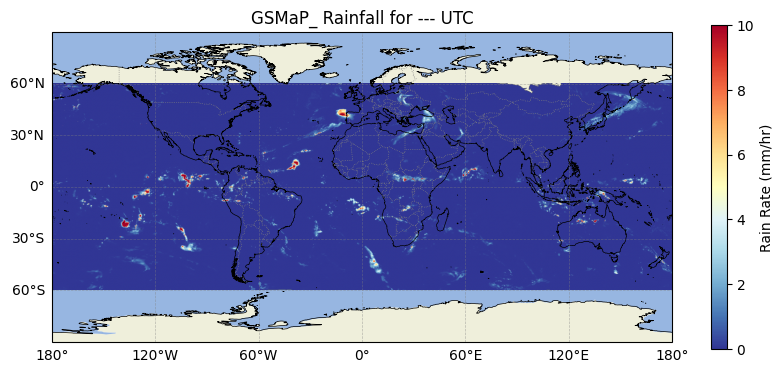

In [14]:
import gzip
import netCDF4
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# Replace 'path_to_your_file.gz' with the actual path
file_path = 'pyForTraCC/data/benchmark/gsmap/standard/v8/hourly/2024/01/01/gsmap_mvk.20240101.0100.v8.1000.0.dat.gz'
#file_path = 'pyForTraCC/data/doneg/nrt/2024/05/05/gsmap_nrt.20240505.0700.dat.gz'

#n_lon = 880 #3600 #500 #
#n_lat = 970 #1200 #680 #
n_lon = 3600 #500 #
n_lat = 1200 #680 #
#extent=[-120, -23, -55, 33]
try:
    with gzip.open(file_path, 'rb') as f:
        raw_data = f.read()

    if not raw_data:
        print("Error: The gzipped file is empty or corrupted.")
    else:
        data_array = np.frombuffer(raw_data, dtype='<f4').copy()
        #data_array = np.frombuffer(raw_data, dtype=np.float32).copy()

        expected_size = n_lon * n_lat
        if data_array.size != expected_size:
            print(f"Error: Mismatched data size. Found {data_array.size} elements, expected {expected_size}.")
        else:
            data_grid = data_array.reshape(n_lat, n_lon)
            data_grid[data_grid < 0] = np.nan

            print(f"Data grid shape: {data_grid.shape}")

            # --- Cartopy plotting ---
            fig = plt.figure(figsize=(10, 6))
            ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

            ax.set_global()
            #extent = [-120, -23, -55, 33]  # Example: A box covering Western Europe
            #ax.set_extent(extent, crs=ccrs.PlateCarree())
            ax.coastlines(resolution='50m', color='black', linewidth=0.5)
            ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='gray', linewidth=0.5)
            ax.add_feature(cfeature.LAND)
            ax.add_feature(cfeature.OCEAN)

            # Plot data with transform
            img = ax.imshow(data_grid, cmap='RdYlBu_r', vmin=0, vmax=10,
                            extent=[-180, 180, -60, 60], origin='upper',
                            transform=ccrs.PlateCarree())

            fig.colorbar(img, ax=ax, label='Rain Rate (mm/hr)', shrink=0.7)
            ax.set_title(f'GSMaP_ Rainfall for --- UTC')

            gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                              linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
            gl.top_labels = False
            gl.right_labels = False

            plt.show()

except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


## Converting GSMap Binary to netCDF

In [37]:
import gzip
import numpy as np
import xarray as xr

infile  = "pyForTraCC/data/benchmark/gsmap/standard/v8/hourly/2024/01/01/gsmap_mvk.20240101.0100.v8.1000.0.dat.gz"  # your file
outfile = "gsmap_mvk_20240101_0100_FIXED_lon180.nc"

# GSMaP grid
nx, ny = 3600, 1200            # 0.1° global, lon x lat
# IMPORTANT: read as LITTLE-endian float32 to match your raw plot
with gzip.open(infile, "rb") as f:
    arr = np.frombuffer(f.read(), dtype="<f4")  # little-endian
arr = arr.reshape(ny, nx)                       # (lat, lon), as in your raw

# Coordinates to match the raw imshow extent/origin exactly
# -180..180 longitudes, row 0 at the TOP (north), so lat must go 60->-60
lon = np.linspace(-180, 180, nx, endpoint=False)         # centers at -179.95, ..., 179.95
lat = np.linspace( 60 - 0.05, -60 + 0.05, ny)            # 59.95, ..., -59.95 (descending)

ds = xr.Dataset(
    data_vars={"precipitation": (("lat", "lon"), arr)},
    coords={"lat": lat, "lon": lon},
    attrs={
        "title": "GSMaP MVK Rainfall (mm/h)",
        "grid": "0.1 deg; lon -180..180, lat 60..-60; row 0 = north (origin='upper')",
        "units": "mm/h",
        "note": "Converted with LITTLE-endian floats to match raw plotting."
    }
)
ds.to_netcdf(outfile)
print("Saved:", outfile)


Saved: gsmap_mvk_20240101_0100_FIXED_lon180.nc


<xarray.Dataset> Size: 17MB
Dimensions:        (lat: 1200, lon: 3600)
Coordinates:
  * lat            (lat) float64 10kB 59.95 59.85 59.75 ... -59.75 -59.85 -59.95
  * lon            (lon) float64 29kB -180.0 -179.9 -179.8 ... 179.7 179.8 179.9
Data variables:
    precipitation  (lat, lon) float32 17MB ...
Attributes:
    title:    GSMaP MVK Rainfall (mm/h)
    grid:     0.1 deg; lon -180..180, lat 60..-60; row 0 = north (origin='upp...
    units:    mm/h
    note:     Converted with LITTLE-endian floats to match raw plotting.

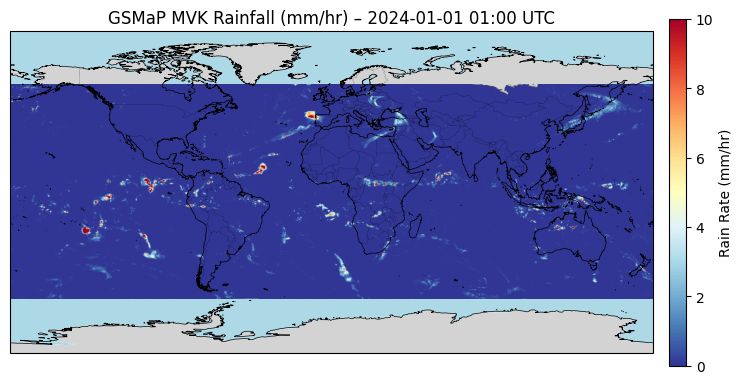

In [12]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

ds = xr.open_dataset("gsmap_mvk_20240101_0100_FIXED_lon180.nc") #("gsmap_netcdf/2018/01/01/gsmap_mvk.20180101.0000.v8.0000.1.nc")
display(ds)
rain = ds["precipitation"].values.copy()

# Apply the SAME mask you used in the raw plot (negatives only)
rain[rain < 0] = np.nan

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines(resolution='50m', linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.3, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Use imshow (not pcolormesh) with the SAME extent/origin as your raw plot
img = ax.imshow(
    rain, cmap='RdYlBu_r', vmin=0, vmax=10,
    extent=[-180, 180, -60, 60], origin='upper', transform=ccrs.PlateCarree()
)

cb = fig.colorbar(img, ax=ax, label='Rain Rate (mm/hr)', shrink=0.75, pad=0.02)
ax.set_title("GSMaP MVK Rainfall (mm/hr) – 2024-01-01 01:00 UTC")
plt.show()



### Quick sanity check (prove arrays are identical)

In [39]:
import gzip, numpy as np, xarray as xr

# read raw again
with gzip.open("pyForTraCC/data/benchmark/gsmap/standard/v8/hourly/2024/01/01/gsmap_mvk.20240101.0100.v8.1000.0.dat.gz", "rb") as f:
    raw = np.frombuffer(f.read(), dtype="<f4").reshape(1200, 3600)

nc = xr.open_dataset("gsmap_mvk_20240101_0100_FIXED_lon180.nc")["precipitation"].values
print("max abs diff:", np.nanmax(np.abs(raw - nc)))  # should be 0.0 (or ~1e-7)


max abs diff: 0.0


### Zarr Plot Viewer

In [1]:
#!/usr/bin/env python3
"""
Plot a GSMaP yearly Zarr (cropped or global) like the original raw-binary plot.

- Uses imshow with origin='upper' (matches raw .dat.gz plotting)
- Masks only negatives (raw behavior). Optionally threshold drizzle.
- Colormap: RdYlBu_r, vmin=0, vmax=10 (same look as your raw example)

Usage:
  python plot_gsmap_zarr.py \
      --zarr /scratch/.../gsmap_mvk_hourly_2019_crop.zarr \
      --time "2019-01-01T01:00:00" \
      --out fig_20190101T0100.png

If --time is omitted, plots the first time slice.
"""

import argparse
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# cartopy is optional but recommended; we fallback gracefully if not available
try:
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    HAS_CARTOPY = True
except Exception:
    HAS_CARTOPY = False


def plot_gsmap_zarr(zarr_path, time_sel=None, out_png=None,
                    drizzle_threshold=None, vmin=0.0, vmax=10.0):
    # Open Zarr (consolidated metadata enabled when you wrote it)
    ds = xr.open_zarr(zarr_path, consolidated=True)

    # Pick a time
    if time_sel is None:
        time_sel = ds.valid_time.values[0].item()  # first timestamp (string)
    da = ds["precipitation"].sel(valid_time=time_sel)

    # Masking: raw behavior = mask only negatives; optional drizzle threshold
    if drizzle_threshold is None:
        da = da.where(da >= 0)
    else:
        da = da.where(da >= drizzle_threshold)

    # Get coords and extent (works for global or cropped)
    lon = ds["lon"].values
    lat = ds["lat"].values
    extent = [float(lon.min()), float(lon.max()), float(lat.min()), float(lat.max())]

    # Load a single 2D slice into memory (safe)
    arr = da.values  # (lat, lon)
    # IMPORTANT: raw plot used origin='upper' (row 0 = north).
    # Our lat in the pipeline is descending (33 -> -55), so no flip is needed.

    title = f"GSMaP MVK Rainfall (mm/h) — {time_sel}"

    if HAS_CARTOPY:
        fig = plt.figure(figsize=(10, 6))
        ax = plt.axes(projection=ccrs.PlateCarree())
        ax.set_extent(extent, crs=ccrs.PlateCarree())
        ax.coastlines(resolution="50m", linewidth=0.6)
        ax.add_feature(cfeature.BORDERS, linewidth=0.3, linestyle=":")
        ax.add_feature(cfeature.LAND, facecolor="lightgray")
        ax.add_feature(cfeature.OCEAN, facecolor="lightblue")

        im = ax.imshow(
            arr, cmap="RdYlBu_r", vmin=vmin, vmax=vmax,
            extent=extent, origin="upper", transform=ccrs.PlateCarree()
        )
        cb = plt.colorbar(im, ax=ax, pad=0.02, shrink=0.8, label="Rain Rate (mm/h)")
        ax.set_title(title)
    else:
        # Fallback: no cartopy, simple imshow with extent
        fig, ax = plt.subplots(figsize=(10, 6))
        im = ax.imshow(
            arr, cmap="RdYlBu_r", vmin=vmin, vmax=vmax,
            extent=extent, origin="upper", aspect="auto"
        )
        cb = plt.colorbar(im, ax=ax, pad=0.02, shrink=0.8, label="Rain Rate (mm/h)")
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")
        ax.set_title(title)

    if out_png:
        plt.savefig(out_png, dpi=300, bbox_inches="tight")
        print(f"✅ Saved: {out_png}")
    else:
        plt.show()


def main():
    p = argparse.ArgumentParser()
    p.add_argument("--zarr", required=True, help="Path to yearly Zarr (e.g., ..._2019_crop.zarr)")
    p.add_argument("--time", default=None, help='ISO time (e.g., "2019-01-01T01:00:00")')
    p.add_argument("--out", default=None, help="Output PNG path (optional)")
    p.add_argument("--drizzle", type=float, default=None,
                   help="Optional threshold to hide drizzle (e.g., 0.2)")
    p.add_argument("--vmin", type=float, default=0.0)
    p.add_argument("--vmax", type=float, default=10.0)
    args = p.parse_args()

    plot_gsmap_zarr(
        zarr_path=args.zarr,
        time_sel=args.time,
        out_png=args.out,
        drizzle_threshold=args.drizzle,
        vmin=args.vmin,
        vmax=args.vmax,
    )


if __name__ == "__main__":
    main()


usage: ipykernel_launcher.py [-h] --zarr ZARR [--time TIME] [--out OUT]
                             [--drizzle DRIZZLE] [--vmin VMIN] [--vmax VMAX]
ipykernel_launcher.py: error: the following arguments are required: --zarr


SystemExit: 2

/prj/cptec/edson.segunda/.conda/envs/dl_pytorch/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3707: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [1]:
# JUPYTER-READY PLOTTING FOR GSMaP ZARR (cropped or global)

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# Try Cartopy (nice maps); fall back to plain matplotlib if not present
try:
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    HAS_CARTOPY = True
except Exception:
    HAS_CARTOPY = False

def plot_gsmap_zarr(
    zarr_path: str,
    time_sel: str | None = None,     # e.g., "2019-01-01T01:00:00"; if None, uses first time
    drizzle_threshold: float | None = None,  # if set (e.g. 0.2), hides drizzle < threshold
    vmin: float = 0.0,
    vmax: float = 10.0,
    save_png: str | None = None,     # e.g., "fig.png"; if None, just shows
    show_coastlines: bool = True
):
    """
    Plot a GSMaP yearly Zarr in the same visual style as the raw binary plot:
      - imshow, origin='upper'
      - RdYlBu_r colormap
      - vmin/vmax linear scaling (default 0..10 mm/h)
      - by default masks ONLY negatives (raw behavior). Optionally mask drizzle.

    Parameters
    ----------
    zarr_path : str
        Path to the Zarr store (e.g., ".../gsmap_mvk_hourly_2019_crop.zarr")
    time_sel : str or None
        ISO 8601 timestamp to select (must exist in ds.valid_time); if None, uses first.
    drizzle_threshold : float or None
        If not None, mask values < threshold (e.g., 0.2 mm/h) to reduce blue haze.
    vmin, vmax : float
        Color scale bounds (mm/h).
    save_png : str or None
        Output PNG filename; if None, displays interactively.
    show_coastlines : bool
        Add coastlines/borders (Cartopy only).
    """
    # Open Zarr (consolidated if you saved it that way)
    ds = xr.open_zarr(zarr_path, consolidated=True)

    # Valid-time handling
    times = ds["valid_time"].values
    if times.size == 1:
        raise ValueError("Dataset has no valid_time entries.")
    if time_sel is None:
        time_sel = times[1].item() if hasattr(times[1], "item") else str(times[1])

    # Select variable/time
    da = ds["precipitation"].sel(valid_time=time_sel)

    # Masking to mimic raw behavior: only negatives → NaN
    if drizzle_threshold is None:
        da = da.where(da >= 0)
    else:
        da = da.where(da >= drizzle_threshold)

    # Pull coords; extent works for cropped or global datasets
    lon = ds["lon"].values
    lat = ds["lat"].values
    extent = [float(lon.min()), float(lon.max()), float(lat.min()), float(lat.max())]

    # 2D array for plotting; IMPORTANT: lat is descending in your pipeline,
    # so origin='upper' displays North at top (matching raw binary plots).
    arr = da.values

    title = f"GSMaP MVK Rainfall (mm/h) — {time_sel}"

    if HAS_CARTOPY:
        fig = plt.figure(figsize=(10, 6))
        ax = plt.axes(projection=ccrs.PlateCarree())
        ax.set_extent(extent, crs=ccrs.PlateCarree())
        if show_coastlines:
            ax.coastlines(resolution="50m", linewidth=0.6)
            ax.add_feature(cfeature.BORDERS, linewidth=0.3, linestyle=":")
            ax.add_feature(cfeature.LAND, facecolor="lightgray")
            ax.add_feature(cfeature.OCEAN, facecolor="lightblue")

        im = ax.imshow(
            arr, cmap="RdYlBu_r", vmin=vmin, vmax=vmax,
            extent=extent, origin="upper", transform=ccrs.PlateCarree()
        )
        cb = plt.colorbar(im, ax=ax, pad=0.02, shrink=0.8, label="Rain Rate (mm/h)")
        ax.set_title(title)
    else:
        # Fallback without Cartopy
        fig, ax = plt.subplots(figsize=(10, 6))
        im = ax.imshow(
            arr, cmap="RdYlBu_r", vmin=vmin, vmax=vmax,
            extent=extent, origin="upper", aspect="auto"
        )
        cb = plt.colorbar(im, ax=ax, pad=0.02, shrink=0.8, label="Rain Rate (mm/h)")
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")
        ax.set_title(title)

    if save_png:
        plt.savefig(save_png, dpi=300, bbox_inches="tight")
        print(f"✅ Saved: {save_png}")
    else:
        plt.show()

    # Print a quick helper for users
    first_t = times[0].item() if hasattr(times[0], "item") else str(times[0])
    last_t  = times[-1].item() if hasattr(times[-1], "item") else str(times[-1])
    print(f"Time range in dataset: {first_t}  →  {last_t}")
    print(f"Plotted timestamp:     {time_sel}")


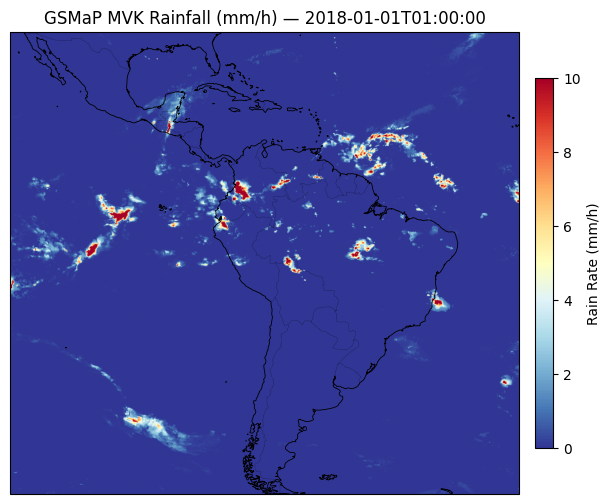

Time range in dataset: 2018-01-01T00:00:00  →  2018-12-31T23:00:00
Plotted timestamp:     2018-01-01T01:00:00


In [3]:
# 1) BASIC: plot first time slice
plot_gsmap_zarr(
    zarr_path= "/scratch/cptec/edson.segunda/gsmap_yearly_crop/gsmap_mvk_hourly_2018_crop.zarr"
)

In [23]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# =============================
#  CONFIGURATION
# =============================
ZARR_PATH = "gsmap_yearly_crop/gsmap_mvk_hourly_2018_crop.zarr"
SOURCE_NAMES = ["NOW", "MVK", "NRT", "MERGE", "IMERG", "OBSGRID"]

print(f"Opening Zarr store: {ZARR_PATH}")
ds = xr.open_zarr(ZARR_PATH, chunks={})
print(ds)


Opening Zarr store: gsmap_yearly_crop/gsmap_mvk_hourly_2018_crop.zarr
<xarray.Dataset> Size: 30GB
Dimensions:        (valid_time: 8760, lat: 880, lon: 970)
Coordinates:
  * lat            (lat) float32 4kB 32.95 32.85 32.75 ... -54.75 -54.85 -54.95
  * lon            (lon) float32 4kB -120.0 -119.9 -119.8 ... -23.3 -23.2 -23.1
  * valid_time     (valid_time) <U19 666kB '2018-01-01T00:00:00' ... '2018-12...
Data variables:
    precipitation  (valid_time, lat, lon) float32 30GB dask.array<chunksize=(168, 220, 242), meta=np.ndarray>
Attributes:
    grid:         0.1 deg; lon [-180,180) convention; lat 60..-60 (descending)
    note:         Hourly GSMaP data concatenated with ISO8601 valid_time and ...
    region:       lat -55.0 to 33.0, lon -120.0 to -23.0
    source:       GSMaP v8 (hourly)
    source_file:  pyForTraCC/data/benchmark/gsmap/standard/v8/hourly/2018/01/...
    title:        GSMaP MVK Hourly Rainfall 2018 (cropped South America)


### Regridding Era5 Data

In [9]:
import xarray as xr
file = "pyForTraCC/data/training/era5/relative_humidity-700hpa_2018.nc"
era5nc = xr.open_dataset(file)
era5nc

<xarray.Dataset> Size: 5GB
Dimensions:         (valid_time: 8760, pressure_level: 1, latitude: 353,
                     longitude: 389)
Coordinates:
  * valid_time      (valid_time) datetime64[ns] 70kB 2018-01-01 ... 2018-12-3...
  * pressure_level  (pressure_level) float64 8B 700.0
  * latitude        (latitude) float64 3kB 33.0 32.75 32.5 ... -54.75 -55.0
  * longitude       (longitude) float64 3kB -120.0 -119.8 ... -23.25 -23.0
    number          int64 8B ...
    expver          (valid_time) <U4 140kB ...
Data variables:
    r               (valid_time, pressure_level, latitude, longitude) float32 5GB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-10-22T23:30 GRIB to CDM+CF via cfgrib-0.9.1...

In [ ]:
import xarray as xr
import xesmf as xe
from pathlib import Path

# ============================================================
# CONFIGURATION
# ============================================================

ERA5_DIR = Path("pyForTraCC/data/training/era5/")
OUT_DIR  = Path("/scratch/cptec/edson.segunda/era5_regridded_zarr/")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Load GSMaP grid from your cropped dataset
GSMAP_GRID = "/scratch/cptec/edson.segunda/gsmap_yearly_crop/gsmap_mvk_hourly_2019_crop.zarr"
ds_gsmap = xr.open_zarr(GSMAP_GRID, consolidated=True)

target_lon = ds_gsmap["lon"]
target_lat = ds_gsmap["lat"]
print(f"GSMaP grid: {len(target_lat)} lat × {len(target_lon)} lon")

# ============================================================
# FUNCTION: regrid and save
# ============================================================

def regrid_era5_to_gsmap(era5_file: Path):
    print(f"📘 Processing {era5_file.name}")
    ds_in = xr.open_dataset(era5_file)

    # Detect coordinate names automatically
    if "latitude" in ds_in.coords and "longitude" in ds_in.coords:
        ds_in = ds_in.rename({"latitude": "lat", "longitude": "lon"})
    elif "Latitude" in ds_in.coords and "Longitude" in ds_in.coords:
        ds_in = ds_in.rename({"Latitude": "lat", "Longitude": "lon"})

    if "lat" not in ds_in.coords or "lon" not in ds_in.coords:
        raise ValueError(f"❌ No lat/lon coordinates in {era5_file}")

    # Select variables that depend on lat/lon
    vars_with_latlon = [v for v in ds_in.data_vars if {"lat", "lon"} <= set(ds_in[v].dims)]
    if not vars_with_latlon:
        print(f"⚠️  No variables with (lat, lon) in {era5_file.name}")
        return

    print(f"📊 Variables to regrid: {vars_with_latlon}")

    # Build regridder once
    regridder = xe.Regridder(
        ds_in,
        {"lon": target_lon, "lat": target_lat},
        method="bilinear",
        periodic=False,
        reuse_weights=False
    )

    # Apply to all spatial variables
    ds_out = xr.Dataset()
    for v in vars_with_latlon:
        print(f"  → Regridding {v}")
        ds_out[v] = regridder(ds_in[v])

    # Attach coordinates and time
    ds_out["lat"] = target_lat
    ds_out["lon"] = target_lon
    if "valid_time" in ds_in.coords:
        ds_out = ds_out.assign_coords(time=ds_in["valid_time"])

    ds_out.attrs.update(
        source=str(era5_file),
        note="Regridded to GSMaP 0.1° grid (bilinear interpolation)"
    )

    # Save to Zarr (compressed)
    zarr_path = OUT_DIR / (era5_file.stem + "_gsmapgrid.zarr")
    print(f"💾 Saving → {zarr_path}")
    ds_out.to_zarr(zarr_path, mode="w", consolidated=True)
    print("✅ Done\n")

    ds_in.close()
    ds_out.close()


# ============================================================
# MAIN EXECUTION
# ============================================================

for era5_file in sorted(ERA5_DIR.glob("*.nc")):
    regrid_era5_to_gsmap(era5_file)


GSMaP grid: 880 lat × 970 lon
📘 Processing relative_humidity-700hpa_2018.nc
📊 Variables to regrid: ['r']
  → Regridding r


In [4]:
import xarray as xr 

eranc = xr.open_zarr("era5_regridded_zarr/tcwv_orography_2024_gsmapgrid.zarr", chunks={})
eranc

<xarray.Dataset> Size: 60GB
Dimensions:     (valid_time: 8784, lat: 880, lon: 970)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 70kB 2024-01-01 ... 2024-12-31T23...
  * lat         (lat) float32 4kB 32.95 32.85 32.75 ... -54.75 -54.85 -54.95
  * lon         (lon) float32 4kB -120.0 -119.9 -119.8 ... -23.3 -23.2 -23.1
    expver      (valid_time) <U4 141kB dask.array<chunksize=(8784,), meta=np.ndarray>
    number      int64 8B ...
    time        (valid_time) datetime64[ns] 70kB dask.array<chunksize=(8784,), meta=np.ndarray>
Data variables:
    slor        (valid_time, lat, lon) float32 30GB dask.array<chunksize=(1255, 51, 56), meta=np.ndarray>
    tcwv        (valid_time, lat, lon) float32 30GB dask.array<chunksize=(1255, 51, 56), meta=np.ndarray>
Attributes:
    note:     Regridded to GSMaP 0.1° grid (bilinear interpolation, no cached...
    source:   pyForTraCC/data/training/era5/tcwv_orography_2024.nc

<xarray.Dataset> Size: 30GB
Dimensions:     (valid_time: 8784, lat: 880, lon: 970)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 70kB 2024-01-01 ... 2024-12-31T23...
  * lat         (lat) float32 4kB 32.95 32.85 32.75 ... -54.75 -54.85 -54.95
  * lon         (lon) float32 4kB -120.0 -119.9 -119.8 ... -23.3 -23.2 -23.1
    number      int64 8B ...
Data variables:
    v           (valid_time, lat, lon) float32 30GB dask.array<chunksize=(500, 220, 242), meta=np.ndarray>

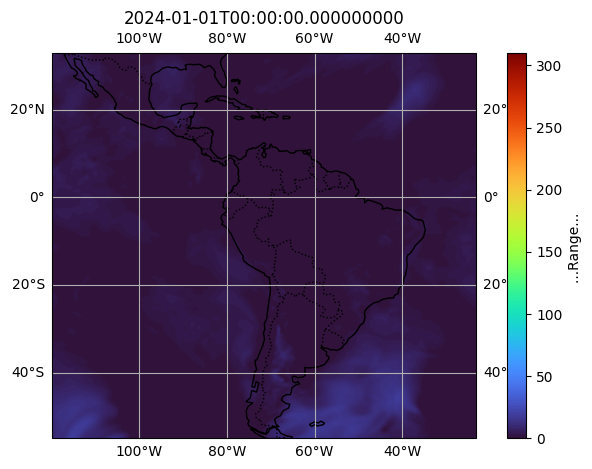

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Open the ERA5 zarr store
#dsz = xr.open_zarr("goes16_c13_zarr/OR_ABI-L1b-RadF-M3C13_G16_s20190461600312_e20190461611091_c20190461611146_c13_bt_gsmapgrid.zarr", consolidated=True)
erazr = xr.open_zarr("era5_regridded_zarr/v_component_of_wind_mean_700_850_2024_gsmapgrid.zarr") 

display(erazr)
# Select the first time step and wind component
bt = erazr["v"].isel(valid_time=0)

# Create a figure and axes with a cartopy projection
plt.figure(figsize=(8, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set the data projection. The coordinates in the xarray dataset are standard latitude/longitude
data_crs = ccrs.PlateCarree()

# Plot the ERA5 data
# Use `ax.imshow()` to display the image on the geographical axes
# The `transform` argument tells cartopy the coordinate system of the data
# The `extent` argument is used to set the boundaries of the data
img = ax.imshow(bt, origin="upper", vmin=0, vmax=310, cmap="turbo", 
                extent=[erazr.lon.min(), erazr.lon.max(), erazr.lat.min(), erazr.lat.max()],
                transform=data_crs)

# Add features to the map for better context
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Add gridlines with labels
ax.gridlines(draw_labels=True)

# Add a color bar and title
plt.colorbar(img, label="...Range... ", orientation='vertical', pad=0.05)
plt.title(str(erazr.valid_time.values[0]))

# Display the plot
plt.show()


### GOES16

In [2]:
import xarray as xr

gnc = xr.open_dataset("goes16_c13/2018/355/04/OR_ABI-L1b-RadF-M3C13_G16_s20183550400331_e20183550411109_c20183550411168.nc")
gnc

<xarray.Dataset> Size: 235MB
Dimensions:                                 (y: 5424, x: 5424,
                                             number_of_time_bounds: 2,
                                             number_of_image_bounds: 2,
                                             num_star_looks: 24, band: 1)
Coordinates:
  * y                                       (y) float32 22kB 0.1518 ... -0.1518
  * x                                       (x) float32 22kB -0.1518 ... 0.1518
    t                                       datetime64[ns] 8B ...
    y_image                                 float32 4B ...
    x_image                                 float32 4B ...
    band_id                                 (band) int8 1B ...
    band_wavelength                         (band) float32 4B ...
    t_star_look                             (num_star_looks) datetime64[ns] 192B ...
    band_wavelength_star_look               (num_star_looks) float32 96B ...
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds,
                                num_star_looks, band
Data variables: (12/31)
    Rad                                     (y, x) float32 118MB ...
    DQF                                     (y, x) float32 118MB ...
    time_bounds                             (number_of_time_bounds) datetime64[ns] 16B ...
    goes_imager_projection                  int32 4B ...
    y_image_bounds                          (number_of_image_bounds) float32 8B ...
    x_image_bounds                          (number_of_image_bounds) float32 8B ...
    ...                                      ...
    percent_uncorrectable_L0_errors         float32 4B ...
    earth_sun_distance_anomaly_in_AU        float32 4B ...
    algorithm_dynamic_input_data_container  int32 4B ...
    processing_parm_version_container       int32 4B ...
    algorithm_product_version_container     int32 4B ...
    star_id                                 (num_star_looks) float32 96B ...
Attributes: (12/29)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v25, 05 July 2013)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    production_data_source:    Realtime
    timeline_id:               ABI Mode 3
    date_created:              2018-12-21T04:11:16.8Z
    time_coverage_start:       2018-12-21T04:00:33.1Z
    time_coverage_end:         2018-12-21T04:11:10.9Z
    id:                        57becdde-67fb-4e49-a43f-c581defbd350

In [1]:
#!/usr/bin/env python3
import re
from pathlib import Path
import numpy as np
import xarray as xr
import xesmf as xe
from datetime import datetime

# ------------------------------------------------------------
# CONFIG
# ------------------------------------------------------------
IN_DIR  = Path("goes16_c13/2019/046/16/")   # where your OR_ABI-L1b-RadF-...C13...nc live (subdirs ok)
OUT_DIR = Path("/scratch/cptec/edson.segunda/goes16_c13_zarr/")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# GSMaP-like target grid (exclusive end so lon=970, lat=880)
LON_MIN, LON_MAX = -120.0, -23.0
LAT_MAX, LAT_MIN = 33.0, -55.0
lon_tgt = np.arange(LON_MIN, LON_MAX, 0.1, dtype=np.float32)   # 970
lat_tgt = np.arange(LAT_MAX, LAT_MIN, -0.1, dtype=np.float32)  # 880

print("Target grid:", len(lat_tgt), "lat  x", len(lon_tgt), "lon")  # 880 x 970

# Optional: persistent regridding weights file for speed (reused across files)
WEIGHTS_FILE = OUT_DIR / "weights_goes16_to_gsmapgrid.nc"

# ------------------------------------------------------------
# Helpers
# ------------------------------------------------------------
def parse_goes_start_time_from_name(name: str) -> datetime:
    """
    Extract start time from GOES filename pattern ... sYYYYDDDHHMMSSS ...
    Example: s20183550400331  -> year=2018, doy=355, time=04:00:33.1
    """
    m = re.search(r"s(\d{4})(\d{3})(\d{2})(\d{2})(\d{2})(\d)", name)
    if not m:
        # fallback to global attrs time_coverage_start if needed
        return None
    year, doy, hh, mm, ss, tenth = m.groups()
    dt = datetime.strptime(f"{year}{doy}{hh}{mm}{ss}", "%Y%j%H%M%S")
    return dt.replace(microsecond=int(tenth)*100_000)

def goes_latlon_from_fixedgrid(ds):
    """
    Compute geodetic latitude/longitude from GOES ABI fixed grid safely.
    Filters invalid pixels (off-Earth) to avoid NaN propagation.
    """
    proj = ds["goes_imager_projection"]

    # Ellipsoid radii and satellite height
    r_eq = proj.semi_major_axis.item()
    r_pol = proj.semi_minor_axis.item()
    H     = proj.perspective_point_height.item() + r_eq
    λ0    = np.deg2rad(proj.longitude_of_projection_origin.item())

    x = ds["x"].values.astype(np.float64)
    y = ds["y"].values.astype(np.float64)
    xx, yy = np.meshgrid(x, y)

    cosx, sinx = np.cos(xx), np.sin(xx)
    cosy, siny = np.cos(yy), np.sin(yy)

    a = sinx**2 + (cosx**2) * (cosy**2 + (r_eq**2 / r_pol**2) * (siny**2))
    b = -2 * H * cosx * cosy
    c = H**2 - r_eq**2

    disc = b**2 - 4*a*c
    disc[disc < 0] = np.nan  # mask off-Earth pixels

    r_s = (-b - np.sqrt(disc)) / (2*a)

    # Mask any non-finite (NaN or inf) values
    mask = np.isfinite(r_s)

    s_x = r_s * cosx * cosy
    s_y = -r_s * sinx * cosy
    s_z = r_s * siny

    # Apply mask
    s_x[~mask] = np.nan
    s_y[~mask] = np.nan
    s_z[~mask] = np.nan

    lat = np.rad2deg(np.arctan((r_eq**2 / r_pol**2) * (s_z / np.sqrt((H - s_x)**2 + s_y**2))))
    lon = np.rad2deg(λ0 - np.arctan(s_y / (H - s_x)))

    print("Latitude range:", np.nanmin(lat), "→", np.nanmax(lat))
    print("Longitude range:", np.nanmin(lon), "→", np.nanmax(lon))

    return lat.astype(np.float32), lon.astype(np.float32)

def radiance_to_bt(rad, ds):
    """Radiance (W m^-2 sr^-1 um^-1) → Brightness Temperature (K) using file Planck constants."""
    fk1 = ds.planck_fk1
    fk2 = ds.planck_fk2
    bc1 = ds.planck_bc1
    bc2 = ds.planck_bc2
    Tb = (fk2 / np.log((fk1 / rad) + 1.0)) - bc1 - bc2
    Tb.name = "brightness_temperature"
    Tb.attrs.update(units="K", long_name="Brightness Temperature (C13 10.3 µm)")
    return Tb

def build_regridder(src_lat2d, src_lon2d):
    """Create (or reuse) a bilinear regridder from curvilinear GOES grid to rectilinear 0.1° grid."""
    grid_in  = {"lat": src_lat2d, "lon": src_lon2d}
    grid_out = {"lat": lat_tgt,   "lon": lon_tgt}
    if WEIGHTS_FILE.exists():
        return xe.Regridder(grid_in, grid_out, method="bilinear", filename=str(WEIGHTS_FILE), reuse_weights=True)
    return xe.Regridder(grid_in, grid_out, method="bilinear", filename=str(WEIGHTS_FILE), reuse_weights=False)

def process_c13_file(nc_path: Path):
    print(f"\n📘 {nc_path.name}")
    ds = xr.open_dataset(nc_path)

    # 1) Channel 13 radiance
    if "Rad" not in ds:
        print("  ⚠️ 'Rad' not found, skipping.")
        ds.close()
        return
    rad = ds["Rad"].astype(np.float32)

    # 2) Radiance -> Brightness Temperature
    bt = radiance_to_bt(rad, ds)

    # 3) Compute lat/lon from fixed grid (correct NOAA formula)
    lat2d, lon2d = goes_latlon_from_fixedgrid(ds)

    # 4) Regrid to 0.1° rectilinear grid (lat 880, lon 970)
    regridder = build_regridder(lat2d, lon2d)
    bt_on_grid = regridder(bt)  # dims -> (y, x) regridded to (lat, lon)

    # 5) Attach coords, add time
    time = parse_goes_start_time_from_name(nc_path.name)
    ds_out = xr.Dataset(
        {
            "brightness_temperature": (("lat", "lon"), bt_on_grid.data.astype(np.float32))
        },
        coords={
            "lat": lat_tgt,
            "lon": lon_tgt
        },
        attrs={
            "source_file": nc_path.name,
            "note": "GOES-16 ABI L1b C13 radiance converted to BT (K), regridded to 0.1° GSMaP grid"
        }
    )
    if time is not None:
        ds_out = ds_out.expand_dims(time=[np.datetime64(time)])
        # For easier concatenation later, reorder dims to (time, lat, lon)
        ds_out = ds_out.transpose("time", "lat", "lon")

    # 6) Save to Zarr
    out_name = nc_path.stem + "_c13_bt_gsmapgrid.zarr"
    zarr_path = OUT_DIR / out_name
    print(f"  💾 Saving -> {zarr_path}")
    # Reasonable chunks for later model use
    ds_out = ds_out.chunk({"time": 1, "lat": 220, "lon": 242})
    ds_out.to_zarr(zarr_path, mode="w", consolidated=True)
    ds.close()
    print("  ✅ Done.")

# ------------------------------------------------------------
# RUN: process one uploaded file first (your uploaded sample)
# ------------------------------------------------------------
#sample = Path("goes16_c13/2019/046/16/OR_ABI-L1b-RadF-M3C13_G16_s20190461600312_e20190461611091_c20190461611146.nc")
#if sample.exists():
#    process_c13_file(sample)

# ------------------------------------------------------------
# (Optional) RUN: process all C13 files under IN_DIR recursively
# ------------------------------------------------------------
# for f in sorted(IN_DIR.rglob("*M3C13*.nc")):
#     process_c13_file(f)



Target grid: 880 lat  x 970 lon


In [2]:
print("Processing...")
sample = Path("goes16_c13/2019/046/16/OR_ABI-L1b-RadF-M3C13_G16_s20190461600312_e20190461611091_c20190461611146.nc")
process_c13_file(sample)
print("...Done...")

Processing...

📘 OR_ABI-L1b-RadF-M3C13_G16_s20190461600312_e20190461611091_c20190461611146.nc
Latitude range: -81.14919574807415 → 81.14715699895837
Longitude range: -156.19307442699602 → 6.196850340460843


/prj/cptec/edson.segunda/.conda/envs/dl_pytorch/lib/python3.12/site-packages/xesmf/frontend.py:716: UserWarning: Using dimensions ('y', 'x') from data variable brightness_temperature as the horizontal dimensions for the regridding.
  warnings.warn(


  💾 Saving -> /scratch/cptec/edson.segunda/goes16_c13_zarr/OR_ABI-L1b-RadF-M3C13_G16_s20190461600312_e20190461611091_c20190461611146_c13_bt_gsmapgrid.zarr
  ✅ Done.
...Done...


In [67]:
import xarray as xr 

# Concatenated:
concat = "goes16_c13_crop_concat_zarr/goes16_c13_crop_concat_2018.zarr"
goes_nc = xr.open_zarr(concat) #("goes16_c13_zarr/OR_ABI-L1b-RadF-M3C13_G16_s20190461600312_e20190461611091_c20190461611146_c13_bt_gsmapgrid.zarr")
goes_nc

<xarray.Dataset> Size: 30GB
Dimensions:                 (time: 8760, lat: 880, lon: 970)
Coordinates:
  * time                    (time) datetime64[ns] 70kB 2018-01-01T00:00:38.70...
  * lat                     (lat) float32 4kB 33.0 32.9 32.8 ... -54.8 -54.9
  * lon                     (lon) float32 4kB -120.0 -119.9 ... -23.2 -23.1
Data variables:
    brightness_temperature  (time, lat, lon) float32 30GB dask.array<chunksize=(1, 220, 242), meta=np.ndarray>
Attributes:
    note:         GOES-16 C13 BT (K) cropped to GSMaP region, concatenated 2018
    source_file:  OR_ABI-L1b-RadF-M3C13_G16_s20180060800398_e20180060811176_c...

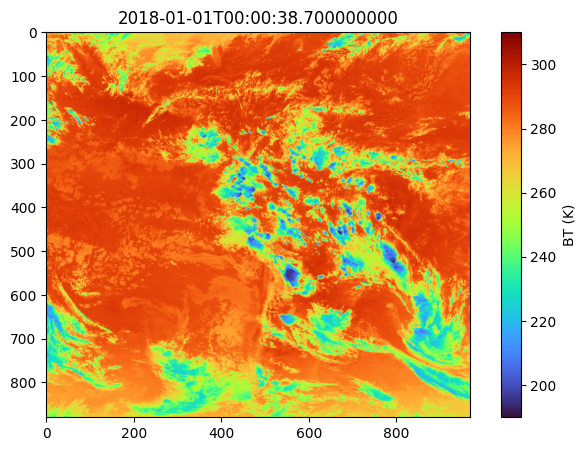

In [68]:
import matplotlib.pyplot as plt
#dsz = xr.open_zarr("goes16_c13_zarr/OR_ABI-L1b-RadF-M3C13_G16_s20190461600312_e20190461611091_c20190461611146_c13_bt_gsmapgrid.zarr", consolidated=True)

dsz = xr.open_zarr(concat) 
bt = dsz["brightness_temperature"].isel(time=0)
plt.figure(figsize=(8,5))
plt.imshow(bt, origin="upper", vmin=190, vmax=310, cmap="turbo")
plt.colorbar(label="BT (K)")
plt.title(str(dsz.time.values[0]))
plt.show()

### Consolidating Zarr file

In [3]:
import zarr
zarr.consolidate_metadata("/scratch/cptec/edson.segunda/era5_regridded_zarr/v_component_of_wind-700hpa_2024_gsmapgrid.zarr")
zarr.consolidate_metadata("/scratch/cptec/edson.segunda/era5_regridded_zarr/v_component_of_wind-850hpa_2024_gsmapgrid.zarr")

print("Consolidation is finished...")

Consolidation is finished...


### Zarr Mean CPU MultiThred

In [ ]:
import xarray as xr
import numpy as np
from multiprocessing import Pool
from tqdm import tqdm
from pathlib import Path

# ============================================================
# CONFIGURATION
# ============================================================

F700 = "/scratch/cptec/edson.segunda/era5_regridded_zarr/v_component_of_wind-700hpa_2024_gsmapgrid.zarr"
F850 = "/scratch/cptec/edson.segunda/era5_regridded_zarr/v_component_of_wind-850hpa_2024_gsmapgrid.zarr"
OUT_PATH = "/scratch/cptec/edson.segunda/era5_regridded_zarr/v_component_of_wind_mean_700_850_2024_gsmapgrid.zarr"

N_PROCS = 8   # Number of CPU processes
CHUNK_SIZE = 500   # number of time steps per worker

VAR_NAME = "v"

# ============================================================
# LOAD DATASETS
# ============================================================
print("📘 Opening Zarr datasets lazily...")
ds700 = xr.open_zarr(F700, consolidated=True)
ds850 = xr.open_zarr(F850, consolidated=True)

# Drop pressure_level dimension if present
if "pressure_level" in ds700.dims:
    ds700 = ds700.squeeze("pressure_level", drop=True)
if "pressure_level" in ds850.dims:
    ds850 = ds850.squeeze("pressure_level", drop=True)

# Align grids (time/lat/lon)
ds700, ds850 = xr.align(ds700, ds850, join="inner")
times = ds700["valid_time"].values
n_times = len(times)
print(f"🕒 Total timesteps: {n_times}")

# ============================================================
# SPLIT INTO CHUNKS
# ============================================================
def make_chunks(n, step):
    return [(i, min(i+step, n)) for i in range(0, n, step)]

chunks = make_chunks(n_times, CHUNK_SIZE)
print(f"📦 Split into {len(chunks)} chunks of {CHUNK_SIZE}")

# ============================================================
# FUNCTION TO PROCESS ONE CHUNK
# ============================================================
def process_chunk(bounds):
    i0, i1 = bounds
    tsel = slice(i0, i1)
    da1 = ds700[VAR_NAME].isel(valid_time=tsel)
    da2 = ds850[VAR_NAME].isel(valid_time=tsel)
    mean = 0.5 * (da1 + da2)
    return mean.compute()  # compute locally in worker

# ============================================================
# PARALLEL EXECUTION
# ============================================================
print(f"🧠 Running in parallel on {N_PROCS} CPU cores...")
with Pool(processes=N_PROCS) as pool:
    results = list(tqdm(pool.imap(process_chunk, chunks), total=len(chunks)))

# Concatenate all chunks along time
mean_concat = xr.concat(results, dim="valid_time")

# ============================================================
# BUILD FINAL DATASET
# ============================================================
ds_mean = xr.Dataset({VAR_NAME: mean_concat})
ds_mean["lat"] = ds700["lat"]
ds_mean["lon"] = ds700["lon"]
ds_mean["valid_time"] = ds700["valid_time"]

ds_mean[VAR_NAME].attrs.update({
    "description": "Mean of v-component of wind between 700 and 850 hPa",
    "units": ds700[VAR_NAME].attrs.get("units", "m/s"),
})

# ============================================================
# SAVE TO ZARR
# ============================================================
print(f"💾 Saving to {OUT_PATH}")
ds_mean = ds_mean.chunk({"valid_time": 500, "lat": 220, "lon": 242})
ds_mean.to_zarr(OUT_PATH, mode="w", consolidated=True)

print("✅ Done!")



📘 Opening Zarr datasets lazily...
🕒 Total timesteps: 8784
📦 Split into 18 chunks of 500
🧠 Running in parallel on 8 CPU cores...


  0%|                                                                                            | 0/18 [00:00<?, ?it/s]

In [1]:
import xarray as xr 

# Concatenated:
concatm = "era5_regridded_zarr/v_component_of_wind_mean_700_850_2024_gsmapgrid.zarr"
era_mean_nc = xr.open_zarr(concatm) #("goes16_c13_zarr/OR_ABI-L1b-RadF-M3C13_G16_s20190461600312_e20190461611091_c20190461611146_c13_bt_gsmapgrid.zarr")
era_mean_nc

<xarray.Dataset> Size: 30GB
Dimensions:     (valid_time: 8784, lat: 880, lon: 970)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 70kB 2024-01-01 ... 2024-12-31T23...
  * lat         (lat) float32 4kB 32.95 32.85 32.75 ... -54.75 -54.85 -54.95
  * lon         (lon) float32 4kB -120.0 -119.9 -119.8 ... -23.3 -23.2 -23.1
    number      int64 8B ...
Data variables:
    v           (valid_time, lat, lon) float32 30GB dask.array<chunksize=(500, 220, 242), meta=np.ndarray>

### Filling the Miising Gap/Data with previows Data

In [59]:
import shutil
from pathlib import Path
import re

# ============================================================
# CONFIGURATION
# ============================================================
ROOT = Path("/scratch/cptec/edson.segunda/goes16_c13/2024")  # root year folder
FILE_PATTERN = re.compile(r"OR_ABI-L1b-RadF-M6C13_G16_s(\d{4})(\d{3})(\d{2})")  # year, doy, hour

# ============================================================
# FIND ALL FILES
# ============================================================
print("🔍 Scanning directories...")
all_files = sorted(ROOT.rglob("*.nc"))
print(f"Found {len(all_files)} NetCDF files.")

# Extract available times (YYYYDOYHH)
times = []
for f in all_files:
    m = FILE_PATTERN.search(f.name)
    if m:
        y, doy, hh = m.groups()
        times.append((int(y), int(doy), int(hh), f))

# Sort by date/time
times.sort(key=lambda x: (x[1], x[2]))

# ============================================================
# DETECT GAPS AND FILL
# ============================================================
filled = 0
for i in range(1, len(times)):
    y, doy, hh, f = times[i]
    y_prev, doy_prev, hh_prev, f_prev = times[i-1]

    # Compute expected next hour
    expected_doy, expected_hh = doy_prev, hh_prev + 1
    if expected_hh == 24:
        expected_hh = 0
        expected_doy += 1

    # If the current file’s day/hour doesn’t match expected → missing frame
    if not (y == y_prev and doy == expected_doy and hh == expected_hh):
        missing_doy, missing_hh = expected_doy, expected_hh
        missing_dir = ROOT / f"{missing_doy:03d}" / f"{missing_hh:02d}"
        missing_dir.mkdir(parents=True, exist_ok=True)
        new_file = missing_dir / f_prev.name.replace(f"{doy_prev:03d}{hh_prev:02d}", f"{missing_doy:03d}{missing_hh:02d}")

        print(f"🕒 Missing → DOY {missing_doy:03d} Hour {missing_hh:02d}")
        print(f"📋 Copying {f_prev.name} → {new_file}")
        shutil.copy2(f_prev, new_file)
        filled += 1

print(f"✅ Filling complete. {filled} missing hours replaced.")


🔍 Scanning directories...
Found 8789 NetCDF files.
🕒 Missing → DOY 004 Hour 18
📋 Copying OR_ABI-L1b-RadF-M6C13_G16_s20240041700209_e20240041709529_c20240041709580.nc → /scratch/cptec/edson.segunda/goes16_c13/2024/004/18/OR_ABI-L1b-RadF-M6C13_G16_s20240041800209_e20240041809529_c20240041809580.nc
🕒 Missing → DOY 276 Hour 15
📋 Copying OR_ABI-L1b-RadF-M6C13_G16_s20242761420205_e20242761429525_c20242761429571.nc → /scratch/cptec/edson.segunda/goes16_c13/2024/276/15/OR_ABI-L1b-RadF-M6C13_G16_s20242761520205_e20242761529525_c20242761529571.nc
✅ Filling complete. 2 missing hours replaced.
